# Лабораторная работа №10. ОСНОВЫ ОБРАБОТКИ ЕСТЕСТВЕННОГО ЯЗЫКА (NLP). ЗАДАЧА ТЕМАТИЧЕСКОГО МОДЕЛИРОВАНИЯ

ЗАДАНИЕ
1. Для выполнения задания используйте датасет с данными о спаме (https://www.kaggle.com/datasets/uciml/sms-spam-collection-dataset).
2. *** Самостоятельно реализовать BoW, TF-IDF.
3. Решить задачу классификации с понижением размерности.
*** Использовать самостоятельно реализованные модели из предыдущих ЛР.
4. Решить задачу тематического моделирования с помощью LDA.

In [160]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import re
import numpy as np
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import (
    f1_score,
    recall_score,
    precision_score,
    accuracy_score,
    roc_curve
)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from gensim import corpora
from gensim.models import LdaModel
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.datasets import fetch_20newsgroups

In [161]:
class output_matrix_or_roc:
    def __init__(self, y_test, y_pred):
        self.y_test = y_test
        self.y_pred = y_pred
    def confusion_matrix(self):
        sns.heatmap(confusion_matrix(self.y_test, self.y_pred), annot=True, fmt='d', cmap='Blues', cbar=False);
        plt.xlabel('Предсказанные классы')
        plt.ylabel('Фактические классы')
        plt.title('Матрица ошибок')
        plt.show()
    def roc_curve(self):
        fpr, tpr, thresholds = roc_curve(self.y_test, self.y_pred)
        fig = plt.figure(figsize=(6, 6))
        plt.plot([0, 1], [0, 1], 'k--')
        plt.plot(fpr, tpr)
        plt.xlabel('FP Rate')
        plt.ylabel('TP Rate')
        plt.title('ROC Curve')
        plt.show()

In [162]:
def metrics(y_true, y_pred):
    print(f"f1_score: {f1_score(y_true, y_pred)}")
    print(f"recall: {recall_score(y_true, y_pred)}")
    print(f"precision: {precision_score(y_true, y_pred)}")
    print(f"accuracy: {accuracy_score(y_true, y_pred)}")

## Задание №1

### Загрузка и предобработка

In [163]:
data = pd.read_csv("spam.csv", encoding="latin-1")

In [164]:
data

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN
...,...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,NaN,NaN,NaN
5568,ham,Will Ì_ b going to esplanade fr home?,NaN,NaN,NaN
5569,ham,"Pity, * was in mood for that. So...any other s...",NaN,NaN,NaN
5570,ham,The guy did some bitching but I acted like i'd...,NaN,NaN,NaN


In [165]:
data.drop(["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis=1, inplace=True)

Очистим текст от ненужных символов и приведем его к нижнему регистру

In [166]:
def TextCleaner(text):
    text = re.sub(r"\W", " ", text)
    text = text.lower()
    text = re.sub(r"\s+", " ", text).strip()
    return text


data["v2"] = data["v2"].apply(TextCleaner)

In [167]:
data.rename(columns={"v1": "mark", "v2": "message"}, inplace=True)

### Разделение на выборки

In [168]:
data["mark"] = data["mark"].map({"ham": 0, "spam": 1})

In [169]:
X_train, X_test, y_train, y_test = train_test_split(
    data["message"], data["mark"], test_size=0.2, random_state=42
)

## Задание №3

Решить задачу классификации с понижением размерности.

In [170]:
count_vectorizer = CountVectorizer()
bow_train = count_vectorizer.fit_transform(X_train)

In [171]:
tfidf_vectorizer = TfidfVectorizer()
tfidf_train = tfidf_vectorizer.fit_transform(X_train)
tfidf_test = tfidf_vectorizer.transform(X_test)

In [172]:
pca = PCA(n_components=20)
X_train_pca = pca.fit_transform(tfidf_train.toarray())
X_test_pca = pca.transform(tfidf_test.toarray())

In [173]:
svc = SVC(C=10, kernel="rbf")
svc.fit(X_train_pca, y_train)

SVC(C=10)

In [174]:
y_pred = svc.predict(X_test_pca)

In [175]:
metrics(y_test, y_pred)

f1_score: 0.8642857142857142
recall: 0.8066666666666666
precision: 0.9307692307692308
accuracy: 0.9659192825112107


In [176]:
matrixNroc = output_matrix_or_roc(y_test, y_pred)

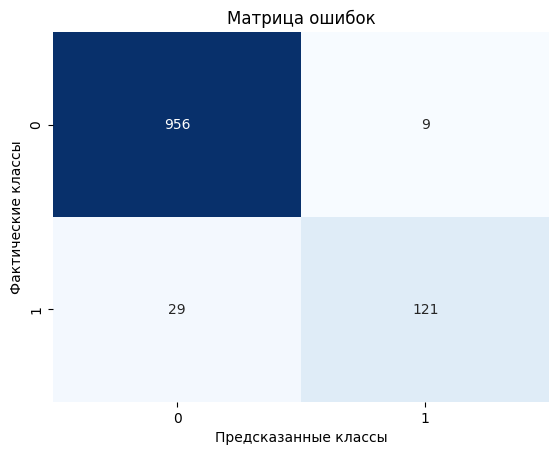

In [177]:
matrixNroc.confusion_matrix()

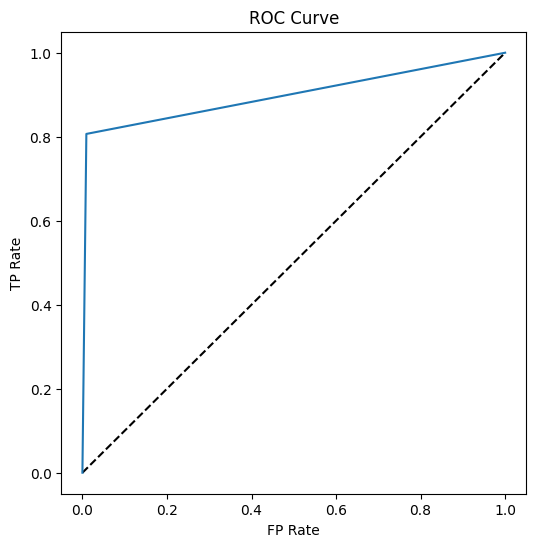

In [178]:
matrixNroc.roc_curve()

## Задание №4

Решить задачу тематического моделирования с помощью LDA

In [179]:
n_samples = 2000
n_features = 1000
n_topics = 10
n_top_words = 20

In [180]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))

In [181]:
print("Loading dataset...")
dataset = fetch_20newsgroups(shuffle=True, random_state=1,
                             remove=('headers', 'footers', 'quotes'))
data_samples = dataset.data[:n_samples]

Loading dataset...


In [183]:
# Use tf (raw term count) features for LDA.
print("Extracting tf features for LDA...")
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2,
                                max_features=n_features,
                                stop_words=list(STOPWORDS))
tf = tf_vectorizer.fit_transform(data_samples)

Extracting tf features for LDA...


In [184]:
lda = LatentDirichletAllocation(n_components=n_topics, max_iter=20,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0).fit(tf)

In [185]:
print_top_words(lda, tf_vectorizer.get_feature_names_out(), 10)

Topic #0:
people said went armenians happened armenian children killed dead came
Topic #1:
people god think law believe time know jesus good fact
Topic #2:
edu mail com send graphics ftp available contact pub code
Topic #3:
hiv health scsi aids disease research medical care dog national
Topic #4:
space earth moon science probe surface lunar mission launch orbit
Topic #5:
like know think time good way ve want new people
Topic #6:
game team play year win flyers games season points goal
Topic #7:
drive windows disk card drives thanks hard use controller problem
Topic #8:
key government chip public use encryption clipper keys security private
Topic #9:
10 55 11 15 12 20 93 18 00 13
